In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from pynwb import TimeSeries
from pynwb import NWBHDF5IO
import pandas as pd
import numpy as np
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
import jax
os.chdir("..")

# Load Data

In [2]:
path = "/stelmo/sam/c3po_datasets/sub-Jenkins_ses-large_desc-train_behavior+ecephys.nwb"

# nwb file
os.path.exists(path)
io = NWBHDF5IO(path, "r")
nwbfile = io.read()

# behavior data
data = []
for object in nwbfile.objects.values():
    if isinstance(object, TimeSeries):
        # if "hand" in object.name.lower() or "hand" in object.description.lower():
        #     data.append(object)
        data.append(object)
behavior_df = {}
for d in data:
    for i, dim in enumerate(["x", "y"]):
        behavior_df[f"{d.name}_{dim}"] = d.data[:, i]
behavior_df = pd.DataFrame(behavior_df, index=d.get_timestamps())
trials_df = nwbfile.trials.to_dataframe()
# calculate and add reach angle to trials_df
reach_angle = [
    np.arctan2(*active_target[0][::-1]) for active_target in trials_df.target_pos.values
]
trials_df["reach_angle"] = reach_angle

# spikes
units_df = nwbfile.units.to_dataframe()

t_spike = []
id_spike = []
for i, spikes in enumerate(units_df["spike_times"]):
    t_spike.extend(spikes)
    id_spike.extend([i] * len(spikes))
ind = np.argsort(t_spike)
t_spike = np.array(t_spike)[ind]
id_spike = np.array(id_spike)[ind]

delta_t = np.diff(t_spike) * 1000  # convert to ms
waveforms = id_spike[1:].astype(np.int16)

ind_valid = np.where(delta_t > 0)[0]
delta_t = delta_t[ind_valid]
waveforms = waveforms[ind_valid]

delta_t.shape, waveforms.shape

np.mean(delta_t), np.std(delta_t), (t_spike.max() - t_spike.min()) / 60

/home/sambray/mambaforge-pypy3/envs/spyglass2025/lib/python3.10/site-packages/hdmf/spec/namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.4.0, loaded version: 2.8.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)


(1.6396087204224739, 2.388700701682356, 24.75024888333333)

In [ ]:
# interval definitions matching those used in the paper
# https://www.nature.com/articles/ncomms13239

preparatory_intervals = []
active_reach_intervals = []
for _, trial in trials_df.iterrows():
    preparatory_intervals.append(
        [trial.target_on_time + 0.15, trial.target_on_time + 0.45]
    )
    active_reach_intervals.append(
        [trial.move_onset_time - 0.05, trial.move_onset_time + 0.25]
    )

In [ ]:
# for i, row in enumerate(trials_df.itertuples()):
#     if i >= 30:
#         break
#     straight = row.target_pos.shape[0]==1
#     print(f"Trial {i}: straight={straight}")
#     color = "green" if straight else "red"

#     ind = (behavior_df.index >= row.target_on_time) & (behavior_df.index <= row.move_onset_time+.25)
#     plt.plot(behavior_df.hand_pos_x[ind],behavior_df.hand_pos_y[ind], color=color)
#     # plt.plot(behavior_df.index[ind]-row.target_on_time, behavior_df

# Load embedding results

In [104]:
from src.c3po.tables.dev_tables import C3POStorage

model_name = "monkey_m1pmd_maze_reach_16d"
# model_name = "monkey_m1pmd_maze_reach_16d_INITIAL"
# # model_name = "monkey_m1pmd_maze_reach_8d_v2"
# model_name = "monkey_m1pmd_maze_reach_8d_INITIAL"
model_name = "monkey_m1pmd_maze_reach_16d_50smooth"

C3POStorage()  # .alter()
key = {"model_name": model_name}
analysis = (C3POStorage & key).fetch_analysis_object()

analysis.load_embedding(f"/stelmo/sam/c3po_results/{key['model_name']}_embedding.npz")

t_interp = np.arange(analysis.t[0], analysis.t[-1], 0.001)
analysis.interpolate_context(t_interp)
analysis.fit_context_pca(interpolated=True)
analysis.embed_context_pca()
# analysis.fit_context_pca(fit_intervals=preparatory_intervals)

# Just showing how to access the variables
t = analysis.t
z = analysis.z
c = analysis.c
c_pca = analysis.c_pca
t_interp = analysis.t_interp
c_interp = analysis.c_interp
c_pca_interp = analysis.c_pca_interp
latent_dim, context_dim = analysis.latent_dim, analysis.context_dim

In [ ]:
# to_delete = [
#     "monkey_m1pmd_maze_reach_8d_quick_move_only",
#     "monkey_m1pmd_maze_reach_8d8d_sharedspace",
#     "monkey_m1pmd_maze_reach_3d3d_sharedspace",
#     "monkey_m1pmd_maze_reach_16c64z",
#     "monkey_m1pmd_maze_reach_16d_noSmooth"]

# delete_keys = [{"model_name": model} for model in to_delete]


# (C3POStorage & delete_keys).delete()

[2025-12-11 17:19:11,460][INFO]: Deleting 5 rows from `sb_c3po`.`c3_p_o_storage`
[2025-12-11 17:19:14,487][INFO]: Deletes committed.


5

# Analyze

In [78]:
val = trials_df.copy()

starts = val.move_onset_time.values

# reach_intervals = np.array([starts - 1, starts + 1.5]).T

intervals = active_reach_intervals
intervals = preparatory_intervals

f, mid, lo, hi = analysis.power_spectrum(
    window_size=200, nfft=20000, intervals=active_reach_intervals, pca=True
)

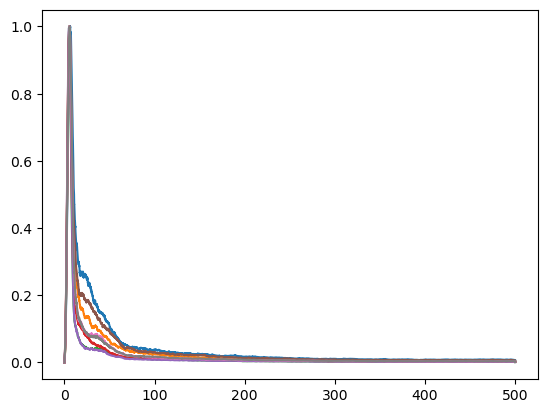

In [79]:
y_plot = mid.T * f[:, None]
y_plot = y_plot / y_plot.max(axis=0)

y_plot = y_plot[:, :]

plt.plot(f, y_plot)
# plt.xscale('log')
# plt.xlim(0, 30)

# Response Curves

16


(-1.0, 3.0)

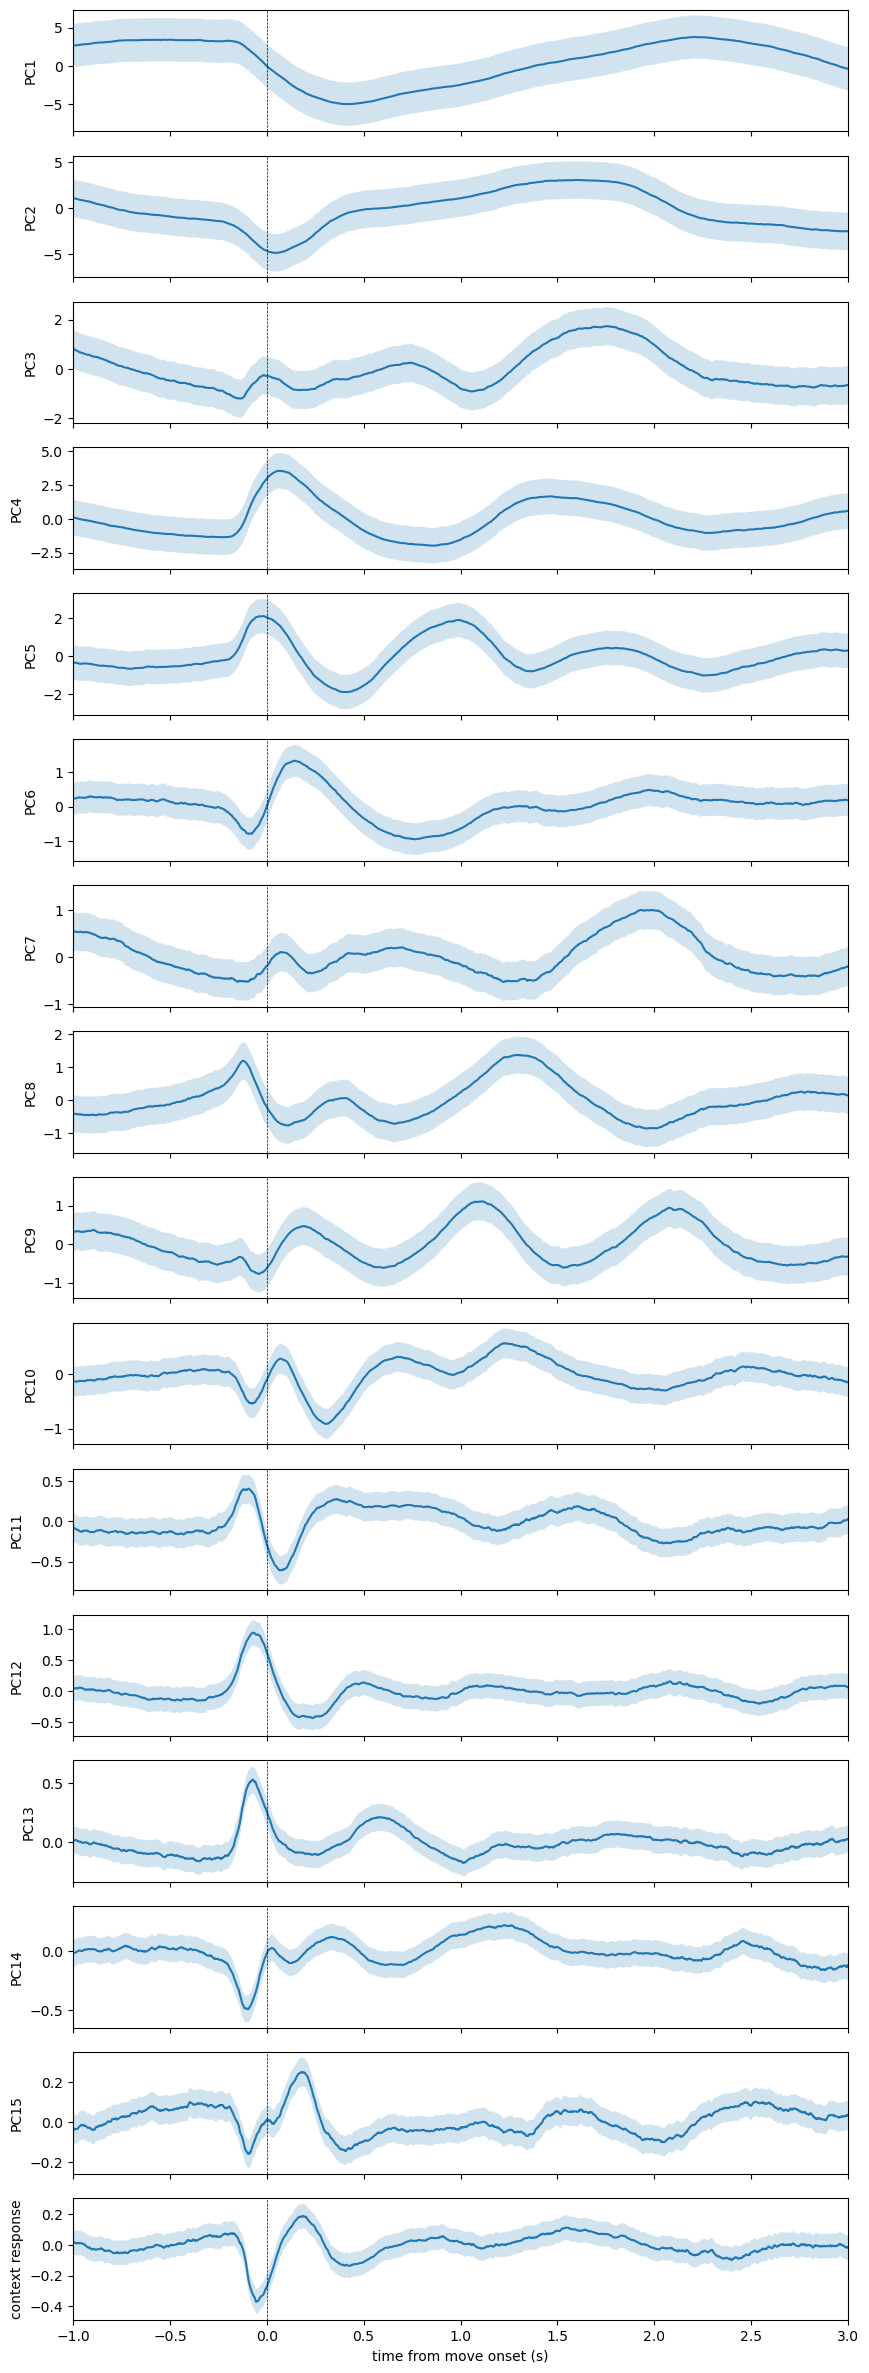

In [97]:
start_times = trials_df.move_onset_time.values
t_rng = (-1, 3)
fig, ax = plt.subplots(nrows=context_dim, sharex=True, figsize=(10, 30))


response = analysis.alligned_response(start_times, t_rng, pca=True)

response.shape
response = np.mean(response, axis=0)

t = np.linspace(t_rng[0], t_rng[1], response.shape[0])
for i, a in enumerate(ax):
    a.plot(
        t,
        response[:, i],
        label=f"PC{i+1}",
    )
    a.fill_between(
        t,
        response[:, i] - np.std(response[:, i]),
        response[:, i] + np.std(response[:, i]),
        alpha=0.2,
    )
    a.set_ylabel(f"PC{i+1}")
    a.axvline(0, color="k", lw=0.5, ls="--")
# plt.plot(
#     t,
#     response[:, :],
# )
# response = np.array([smooth(response[:, i], 100) for i in range(response.shape[-1])]).T


# plt.plot(response[:, 0], response[:, 1], lw=1)
# plt.scatter(response[0, 0], response[0, 1], s=100, alpha=1,c='k')
# plt.xlabel("PC1")
# plt.ylabel("PC2"    )
print(context_dim)
plt.xlabel("time from move onset (s)")
plt.ylabel("context response")
plt.xlim(t_rng)

In [273]:
print(np.mean(trials_df.target_on_time - trials_df.go_cue_time))

print(np.mean(trials_df.target_on_time - trials_df.move_onset_time))
print(np.mean(trials_df.go_cue_time - trials_df.move_onset_time))

-0.6111299999999998
-0.9578180000000021
-0.3466880000000021


/tmp/ipykernel_2417405/2411715783.py:53: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  two_d_ax.scatter(


16


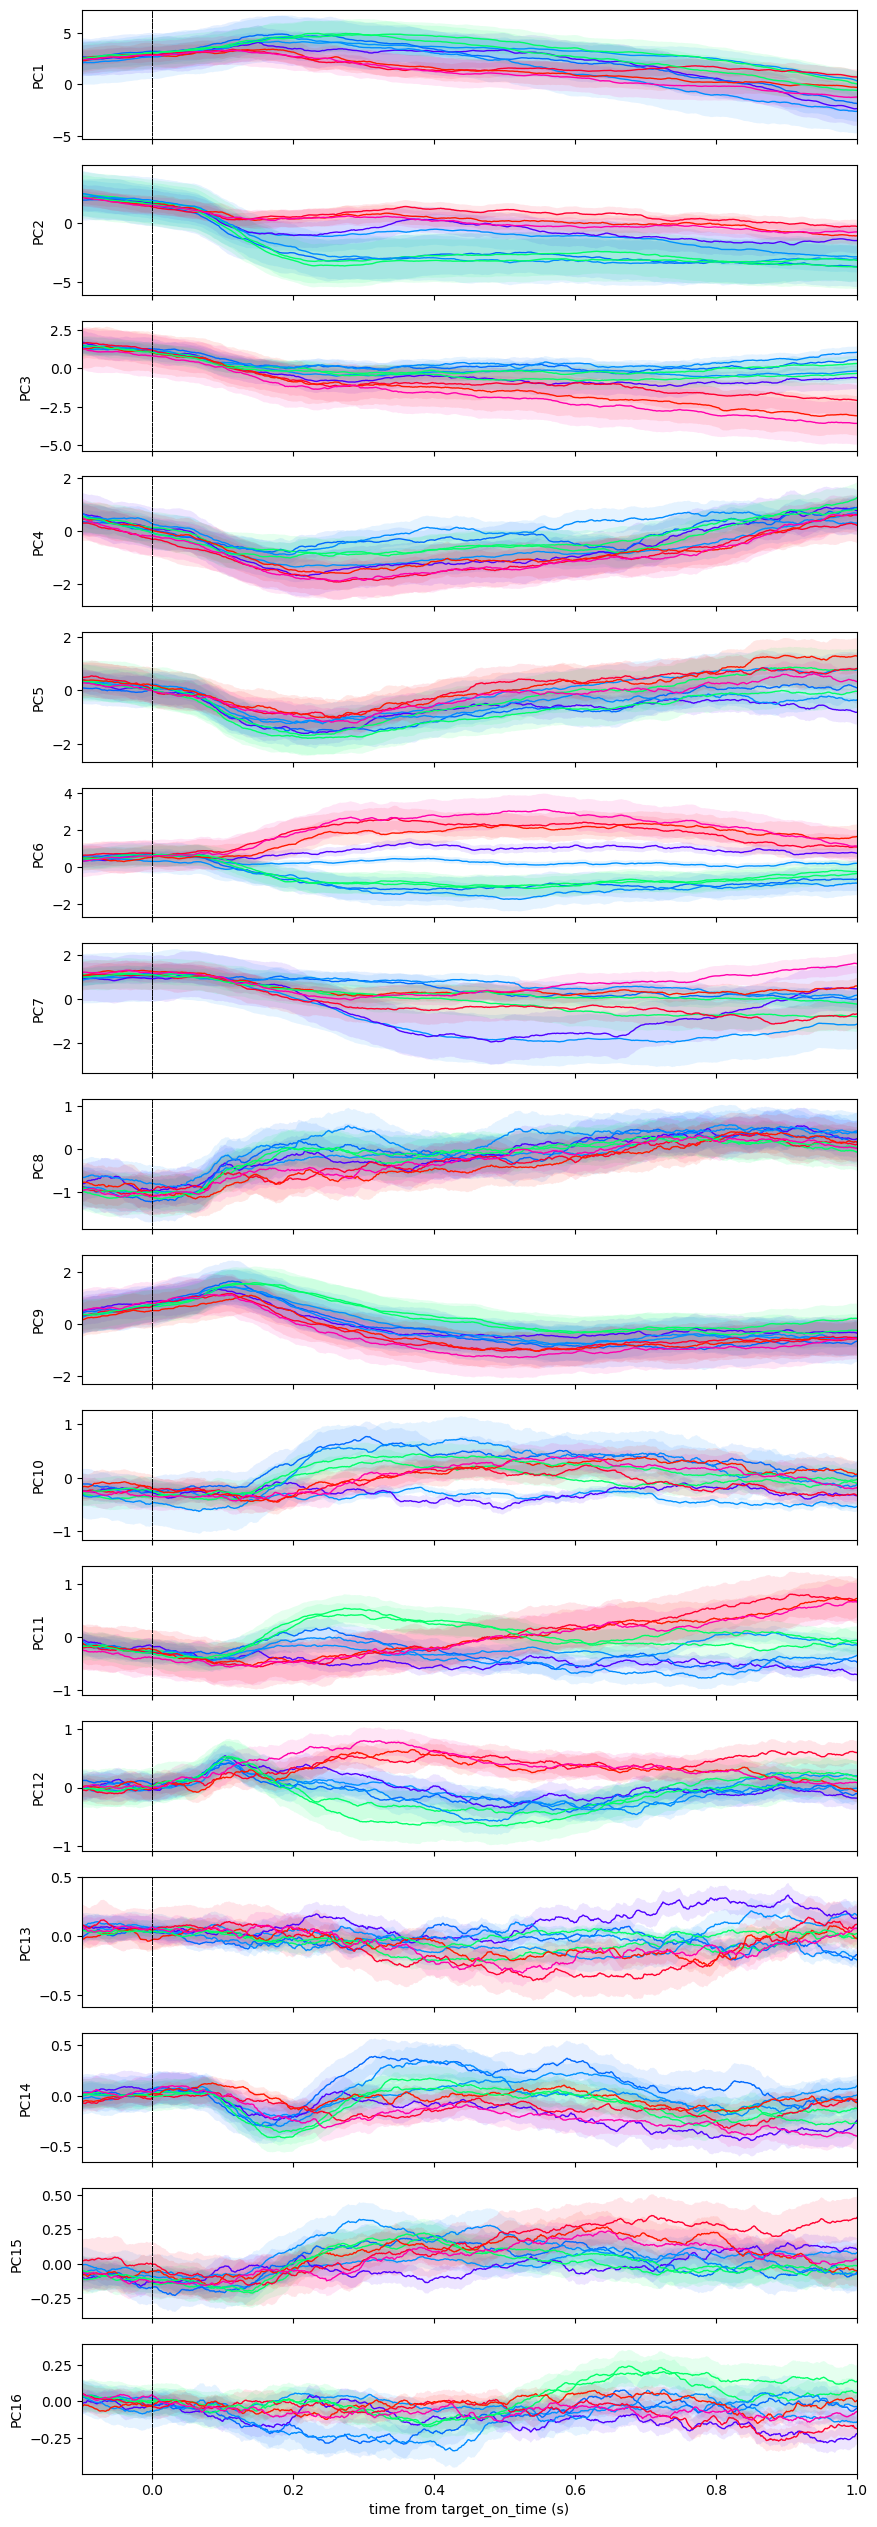

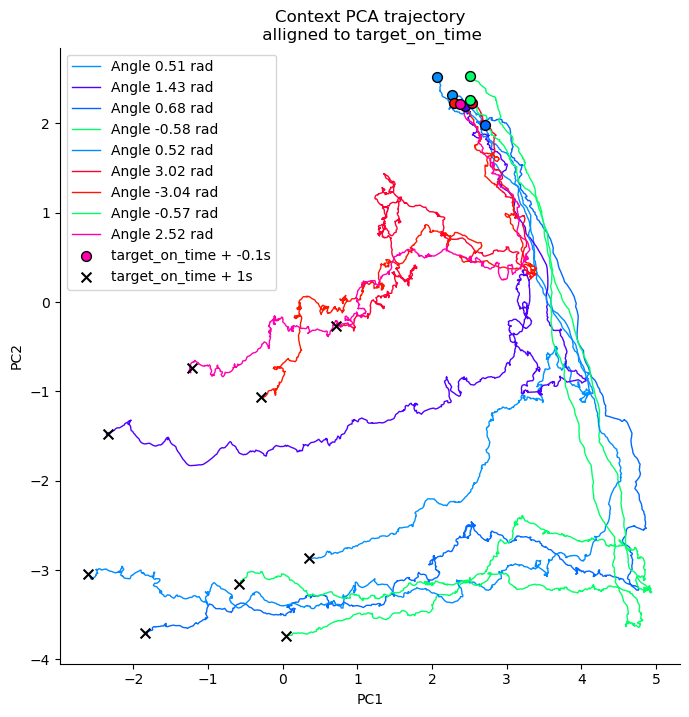

In [98]:
start_times = trials_df.move_onset_time.values
alignment = "move_onset_time"

# start_times = trials_df.go_cue_time.values


start_times = trials_df.target_on_time.values
alignment = "target_on_time"

t_rng = (-0.2, 0.5)
t_rng = -0.1, 1
# t_rng = (-1,2)
# t_rng = (0,.5)
fig, ax = plt.subplots(nrows=context_dim, sharex=True, figsize=(10, 2 * context_dim))

two_d_fig = plt.figure(figsize=(8, 8))
two_d_ax = two_d_fig.add_subplot(1, 1, 1)
# plot_dims = (2,5)
plot_dims = (6, 7)
plot_dims = (0, 1)
# plot_dims=(6,4)

for i_reach, reach_angle in enumerate(trials_df.reach_angle.unique()):
    ind_reach = trials_df.reach_angle == reach_angle
    response = analysis.alligned_response(start_times[ind_reach], t_rng, pca=True)

    response = np.mean(response, axis=0)

    color = plt.cm.hsv((reach_angle + np.pi) / (2 * np.pi))
    t = np.linspace(t_rng[0], t_rng[1], response.shape[0])
    for i, a in enumerate(ax):
        a.plot(
            t, response[:, i], label=f"Angle {reach_angle:.2f} rad", color=color, lw=1
        )
        a.fill_between(
            t,
            response[:, i] - np.std(response[:, i]),
            response[:, i] + np.std(response[:, i]),
            alpha=0.1,
            facecolor=color,
        )
        a.set_ylabel(f"PC{i+1}")
        a.axvline(0, color="k", lw=0.5, ls="--")

    two_d_ax.plot(
        response[:, plot_dims[0]],
        response[:, plot_dims[1]],
        label=f"Angle {reach_angle:.2f} rad",
        color=color,
        lw=1,
        zorder=-1,
    )
    two_d_ax.scatter(
        response[0, plot_dims[0]],
        response[0, plot_dims[1]],
        s=50,
        alpha=1,
        c=color,
        edgecolor="k",
        label=(
            f"{alignment} + {t_rng[0]}s"
            if i_reach == len(trials_df.reach_angle.unique()) - 1
            else None
        ),
    )
    two_d_ax.scatter(
        response[-1, plot_dims[0]],
        response[-1, plot_dims[1]],
        s=50,
        alpha=1,
        # c=color,
        marker="x",
        color="k",
        label=(
            f"{alignment} + {t_rng[1]}s"
            if i_reach == len(trials_df.reach_angle.unique()) - 1
            else None
        ),
    )

print(context_dim)
ax[-1].set_xlabel(f"time from {alignment} (s)")
# plt.ylabel("context response")
ax[0].set_xlim(t_rng)

two_d_ax.set_xlabel(f"PC{plot_dims[0]+1}")
two_d_ax.set_ylabel(f"PC{plot_dims[1]+1}")
two_d_ax.legend()
two_d_ax.set_title("Context PCA trajectory" + "\n alligned to " + alignment + "")
two_d_ax.spines[["right", "top"]].set_visible(False)

In [ ]:
# Find unique conditions
conds = trials_df.set_index(["trial_type", "trial_version"]).index.unique().tolist()

# # Initialize plot
# fig = plt.figure(figsize=(6, 6))
# ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

# Loop over conditions and compute average trajectory
for cond in conds:
    # Find trials in condition
    mask = np.all(trials_df[["trial_type", "trial_version"]] == cond, axis=1)

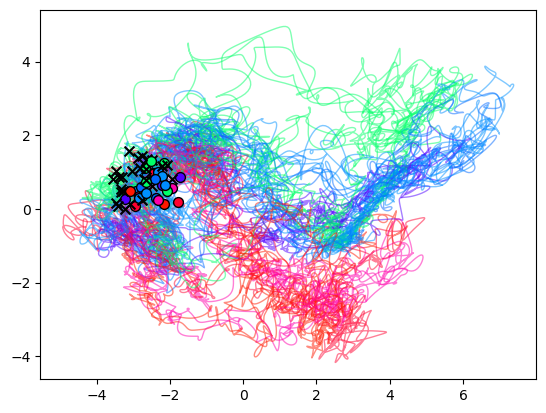

In [90]:
t_rng = (-0.1, 0.5)
t_rng = (-0.5, 1)
t_rng = (-1, 2)
plot_dims = (3, 4)
plot_dims = (0, 1)
plot_dims = (0, 2)
# plot_dims = (1, 4)
smooth_len = 31


def smooth(x, window_len=11, window="hamming"):
    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")
    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")
    if window_len < 3:
        return x
    if window == "hanning":
        w = np.hanning(window_len)
    elif window == "hamming":
        w = np.hamming(window_len)
    elif window == "blackman":
        w = np.blackman(window_len)
    elif window == "gaussian":
        w = np.hanning(window_len)
        w = np.exp(
            -0.5
            * (np.arange(window_len) - window_len // 2) ** 2
            / (window_len // 6) ** 2
        )
        w /= w.sum()
    else:
        raise ValueError("Window is on of 'hanning', 'hamming', 'blackman'")
    y = np.convolve(w / w.sum(), x, mode="valid")
    return y


# Find unique conditions
conds = trials_df.set_index(["trial_type", "trial_version"]).index.unique().tolist()

for i_cond, cond in enumerate(conds):
    # color = plt.cm.hsv(i_cond/len(conds))
    # color=None
    ind = np.all(trials_df[["trial_type", "trial_version"]] == cond, axis=1)
    val = trials_df[ind]

    active_target = trials_df[ind].target_pos.iloc[0][
        trials_df[ind].active_target.iloc[0]
    ]
    reach_angle = np.arctan2(*active_target[::-1])
    color = plt.cm.hsv(reach_angle / (2 * np.pi) + 0.5)

    # val = trials_df[np.logical_and(trials_df.target_dir == direction, trials_df.result =='A')]
    # val = trials_df[
    #     trials_df.target_dir == direction
    # ]
    start_times = val.move_onset_time.values
    response = analysis.alligned_response(start_times, t_rng, pca=True)
    response = np.nanmean(response, axis=0)
    response = np.array(
        [
            smooth(response[:, i], window_len=smooth_len, window="gaussian")
            for i in range(response.shape[1])
        ]
    ).T
    # plt.plot(response[:, 0], label=direction)
    plt.plot(
        response[:, plot_dims[0]],
        response[:, plot_dims[1]],
        label=str(cond),
        lw=1,
        color=color,
        alpha=0.5,
    )
    plt.scatter(
        response[0, plot_dims[0]],
        response[0, plot_dims[1]],
        s=50,
        alpha=1,
        color=color,
        zorder=20,
        edgecolor="k",
    )
    plt.scatter(
        response[-1, plot_dims[0]],
        response[-1, plot_dims[1]],
        s=50,
        alpha=1,
        zorder=20,
        marker="x",
        color="k",
    )
    # plt.legend()

NameError: name 'unique_angles' is not defined

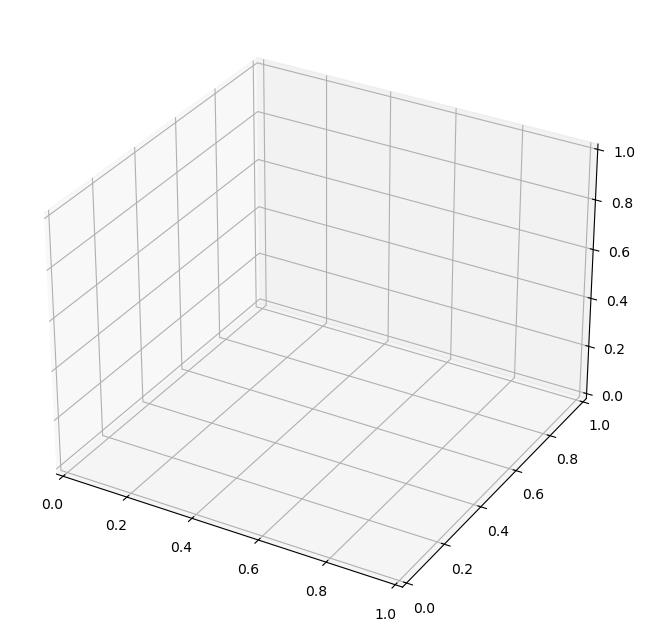

In [91]:
from mpl_toolkits.mplot3d import Axes3D

t_rng = (-0.1, 0.5)
t_rng = (-0.5, 1)
# t_rng = (-1, 2)

plot_dims = (0, 1, 2)
# plot_dims = (1,2,4)
smooth_len = 31
alignment = "move_onset_time"
alignment = "target_on_time"


fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")


# Find unique conditions
# conds = trials_df.set_index(["trial_type", "trial_version"]).index.unique().tolist()

# for i_cond, cond in enumerate(conds):
#     ind = np.all(trials_df[["trial_type", "trial_version"]] == cond, axis=1)

# active_target = trials_df.target_pos.values
# reach_angle = [np.arctan2(*target[0])) for target in active_target]
# unique_angles = np.unique(reach_angle)
# np.sort(unique_angles)
# group_ids = np.zeros_like(reach_angle)
# for i, angle in enumerate(unique_angles):
#     group_ids[np.isclose(reach_angle, angle)] = i
# labels = unique_angles.tolist()

group_feature = "reach_angle"
for i_group, feature in enumerate(trials_df[group_feature].unique()):

    val = trials_df[trials_df[group_feature] == feature]

    color = plt.cm.hsv((feature + np.pi) / (2 * np.pi))

    # active_target = trials_df[ind].target_pos.iloc[0][
    #     trials_df[ind].active_target.iloc[0]
    # ]
    # reach_angle = np.arctan2(*active_target[::-1])
    # color = plt.cm.hsv(reach_angle / (2 * np.pi) + 0.5)

    # val = trials_df[np.logical_and(trials_df.target_dir == direction, trials_df.result =='A')]
    # val = trials_df[
    #     trials_df.target_dir == direction
    # ]
    start_times = val[alignment].values
    response = analysis.alligned_response(start_times, t_rng, pca=True)
    response = np.nanmean(response, axis=0)
    response = np.array(
        [
            smooth(response[:, i], window_len=smooth_len, window="gaussian")
            for i in range(response.shape[1])
        ]
    ).T
    # plt.plot(response[:, 0], label=direction)
    ax.plot(
        response[:, plot_dims[0]],
        response[:, plot_dims[1]],
        response[:, plot_dims[2]],
        label=unique_angles[i_group],
        lw=1,
        color=color,
        alpha=0.5,
    )
    ax.scatter(
        response[0, plot_dims[0]],
        response[0, plot_dims[1]],
        response[0, plot_dims[2]],
        s=50,
        alpha=1,
        color=color,
        zorder=20,
        edgecolor="k",
    )
    ax.scatter(
        response[-1, plot_dims[0]],
        response[-1, plot_dims[1]],
        response[-1, plot_dims[2]],
        s=50,
        alpha=1,
        zorder=20,
        marker="x",
        color="k",
    )
plt.legend(title="Reach angle (rad)")

# Behavior Decoding

In [ ]:
df = trials_df.copy()
reach_intervals = df.move_onset_time.values
train_rng = (-0.1, 0.5)
train_rng = (-0.1, 1)
# train_rng = (-0.5, 1.5)
reach_intervals = np.array(
    [reach_intervals + train_rng[0], reach_intervals + train_rng[1]]
).T

bins = 100  # np.linspace(-15, 15, 100)
c_binned, b1, b2 = analysis.bin_context_by_feature_2d(
    feature_1=behavior_df["hand_pos_x"].values,
    feature_2=behavior_df["hand_pos_y"].values,
    feature_1_times=behavior_df.index.values,
    feature_2_times=behavior_df.index.values,
    valid_intervals=reach_intervals,
    pca=True,
    interpolated=True,
    bins_1=bins,
    bins_2=bins,
)

c_mid = np.array(
    [
        [
            np.nanmedian(b, axis=0) if len(b) else np.nan * np.zeros(context_dim)
            for b in row
        ]
        for row in c_binned
    ]
)

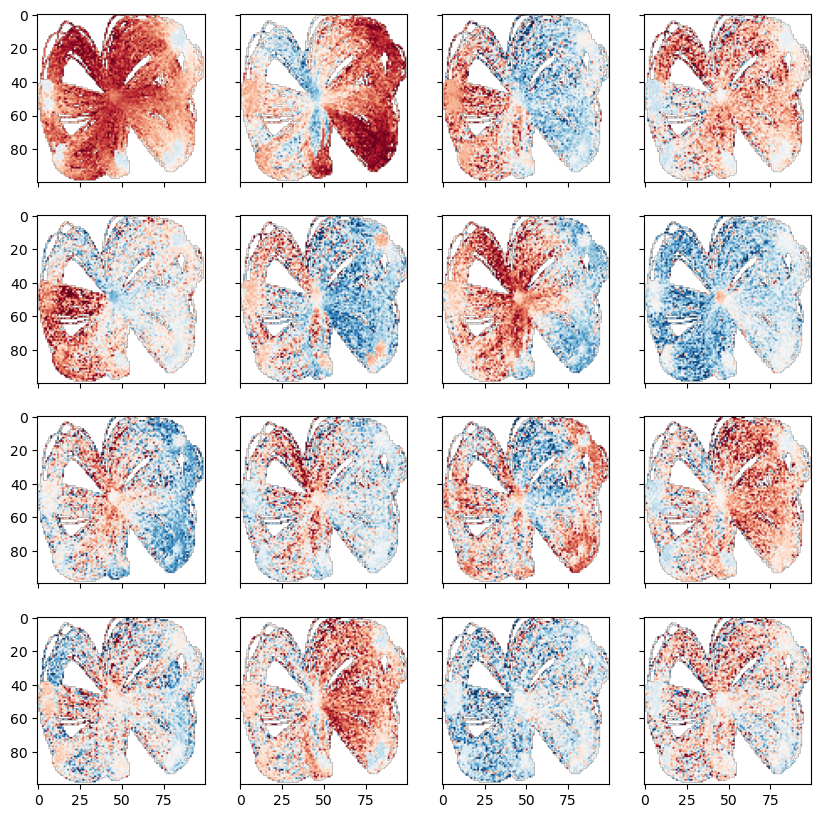

In [399]:
# val = val - np.nanmean(val)
n_r = int(np.sqrt(context_dim))
n_c = int(np.ceil(context_dim / n_r))
fig, ax = plt.subplots(nrows=n_r, ncols=n_c, figsize=(10, 10), sharex=True, sharey=True)
ax = np.ravel(ax)
for i, a in enumerate(ax):
    val = c_mid[:, :, i].T
    val = val / np.nanpercentile(np.abs(val), 97)

    a.imshow(val, cmap="RdBu", clim=(-1, 1))
    # plt.colorbar()

In [ ]:
# Define decodeer type and fit

train_df = trials_df[trials_df.split == "train"]
# train_df = train_df[train_df.ctr_hold_bump == False]
train_intervals = train_df.move_onset_time.values
# train_rng = (-0.1, 0.5)
# train_rng = (-0.1, 1)
train_rng = (-0.5, 1.5)
train_intervals = np.array(
    [train_intervals + train_rng[0], train_intervals + train_rng[1]]
).T

train_intervals[0]

t_feature = behavior_df.index.values
feature = behavior_df[["hand_vel_y", "hand_vel_x"]].values
feature = behavior_df[["hand_pos_x", "hand_pos_y"]].values

# feature = behavior_df[["hand_pos_y"]].values

print(np.nanmin(feature), np.nanmax(feature))
# analysis.initialize_decoder("knn", n_neighbors=30, weights='distance', metric='cosine')
analysis.initialize_decoder(
    model_type="knn",
    feature_prediction_delay=0.08,
    n_neighbors=300,
    # weights="uniform",
    weights="distance",
    # metric="cosine",
    metric="euclidean",
)


# analysis.initialize_decoder(
#     "discretized_regression", n_bins=100, max_iter=1000, balance_groups=True, multidim=True
# )

# analysis.initialize_decoder(
#     "linear",
# )
# analysis.fit_decoder(feature, t_feature, intervals=train_intervals,pca=False,interpolate=True, smooth_context=20)

analysis.fit_decoder(
    feature,
    t_feature,
    intervals=train_intervals,
    # pca=True,
    pca=False,
    # decode_dim = slice(0,3),
    interpolate=True,
    smooth_context=11,
    # balance_features=True,
    # balance_features_bins=int(20),
    # balance_features_min_count=50,
)

-149.82587680040115 165.300763502679


In [ ]:
# Decode on test set

test_df = trials_df[trials_df.split == "val"]
# test_df = test_df[test_df.ctr_hold_bump == False]

# test_df = train_df

test_intervals = test_df.move_onset_time.values
test_rng = (-0.5, 1)
test_rng = (-0.5, 0.5)
test_rng = -1, 1
test_intervals = np.array(
    [test_intervals + test_rng[0], test_intervals + test_rng[1]]
).T

# test_intervals = test_intervals[:5]

from tqdm import tqdm
from multiprocessing import Pool

# def predict_interval(interval):
#     return analysis.predict_decoder(
#         interval, interpolate=True, smooth_context=41
#     )

# predicted = []
# with Pool(processes=64) as pool:
#     for result in tqdm(
#         pool.imap_unordered(analysis.predict_decoder, test_intervals, chunksize=8),
#         total=len(test_intervals),
#     ):
#         predicted.append(result)
# predicted = [
#     analysis.predict_decoder(interval, interpolate=True, smooth_context=31)
#     for interval in tqdm(test_intervals)
# ]
predicted = []
for interval in tqdm(test_intervals):
    predicted.append(
        analysis.predict_decoder(interval, interpolate=True, smooth_context=3)
    )

# test_directions = test_df.cond_dir.values
# test_bump = test_df.ctr_hold_bump.values

 18%|█▊        | 22/125 [00:11<00:54,  1.88it/s]


KeyboardInterrupt: 

Text(0.5, 0, 'time from move onset (s)')

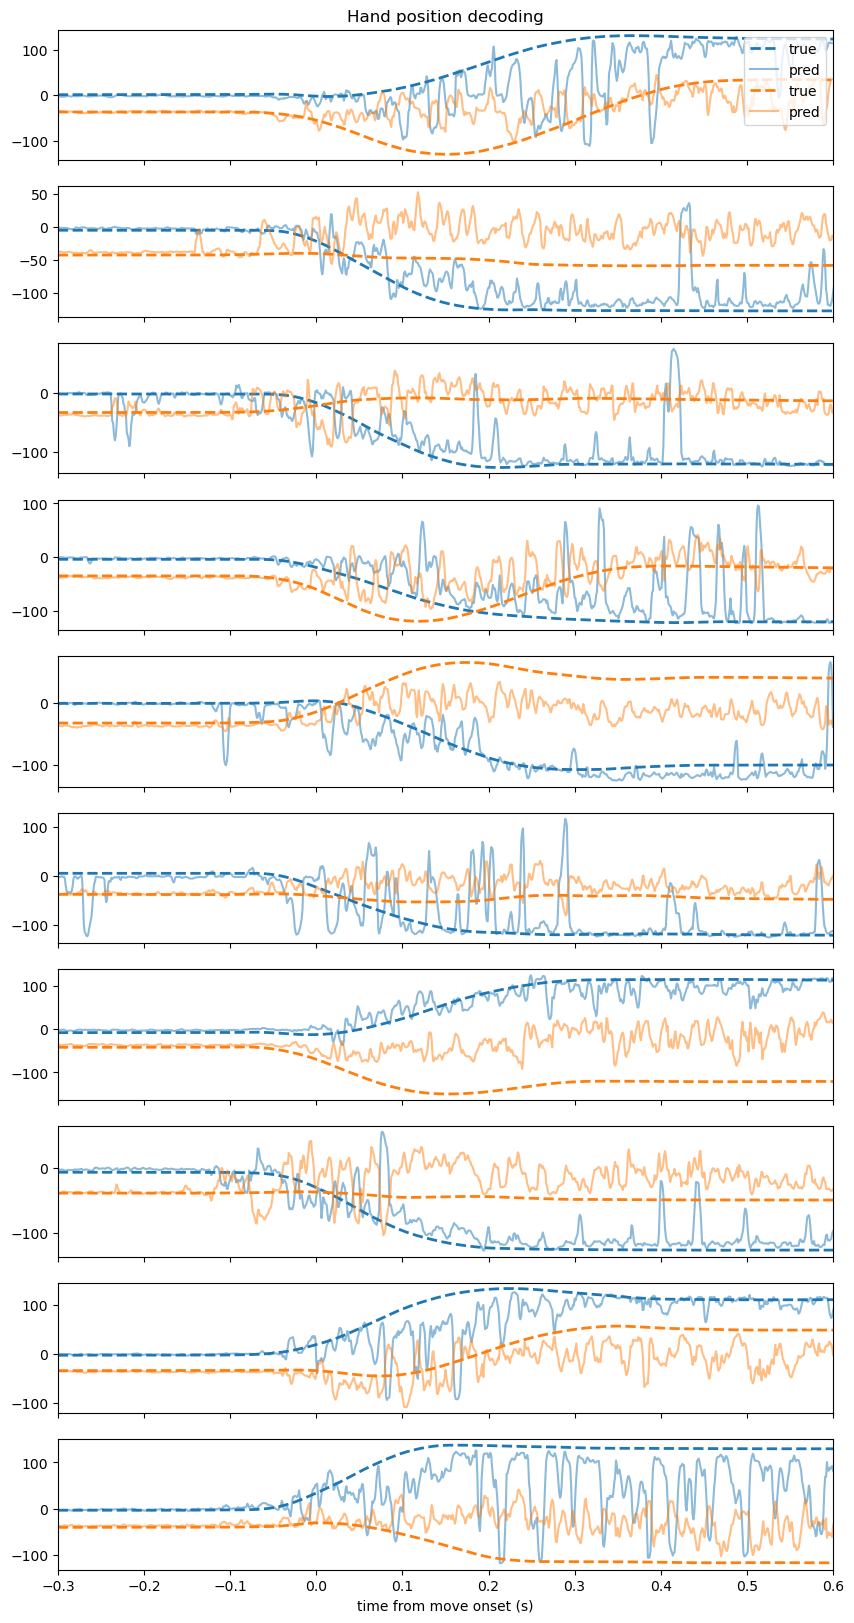

In [ ]:
# Example result traces

fig, ax = plt.subplots(nrows=10, sharex=True, figsize=(10, 20))

# ind = np.where(np.logical_and(test_directions == 0, test_bump == 0))[0]
# ind = np.where(test_bump == 0)[0][10:]
ind = np.arange(len(predicted))
for i, ind_i in enumerate(np.random.choice(ind, size=10, replace=False)):
    t, pred = predicted[ind_i]

    # pred[:, 0] = np.convolve(
    #     pred[:, 0], np.hanning(21) / np.hanning(21).sum(), mode="same"
    # )
    # pred[:, 1] = np.convolve(
    #     pred[:, 1], np.hanning(21) / np.hanning(21).sum(), mode="same"
    # )
    # pred = gaussian_filter1d(pred, 10, axis=0, mode="nearest")

    if t.size == 0:
        continue
    ind_behavior = np.digitize(t, behavior_df.index.values) - 1

    for j in range(feature.shape[1]):
        ax[i].plot(
            behavior_df.index.values[ind_behavior] - t[0] + test_rng[0],
            feature[ind_behavior, j],
            color=f"C{j}",
            ls="--",
            lw=2,
            # s=1,
            label="true",
        )
        ax[i].plot(
            t - t[0] + test_rng[0], pred[:, j], color=f"C{j}", alpha=0.5, label="pred"
        )

# ax[0].set_title("Hand velocity decoding")
ax[0].set_title("Hand position decoding")
ax[0].legend(loc="upper right")
ax[0].set_xlim(-0.1, 1)
plt.xlim(-0.3, 0.6)
plt.xlabel("time from move onset (s)")
# for t,pred in predicted[:10]:
#     if t.size==0: continue
#     ind_behavior = np.digitize(t, behavior_df.index.values) - 1
#     plt.plot(t-t[0], pred, color='C0', alpha=0.3)
#     plt.scatter(behavior_df.index.values[ind_behavior]-t[0], feature[ind_behavior,0], color='k', s=1)

# Feature testing

In [403]:
df = trials_df.copy()
reach_intervals = df.move_onset_time.values
train_rng = (-0.1, 0.5)
train_rng = (-0.1, 1)
# train_rng = (-0.5, 1.5)
reach_intervals = np.array(
    [reach_intervals + train_rng[0], reach_intervals + train_rng[1]]
).T

feature1 = "hand_vel_x"
feature2 = "hand_vel_y"
bins = 100

# feature1 = "eye_pos_x"
# feature2 = "eye_pos_y"
# bins = np.linspace(-100,100,30)

# feature1 = "cursor_pos_x"
# feature2 = "cursor_pos_y"

# bins = 100  # np.linspace(-15, 15, 100)
c_binned, b1, b2 = analysis.bin_context_by_feature_2d(
    feature_1=behavior_df[feature1].values,
    feature_2=behavior_df[feature2].values,
    feature_1_times=behavior_df.index.values,
    feature_2_times=behavior_df.index.values,
    valid_intervals=reach_intervals,
    pca=True,
    interpolated=True,
    bins_1=bins,
    bins_2=bins,
)

c_mid = np.array(
    [
        [
            np.nanmedian(b, axis=0) if len(b) else np.nan * np.zeros(context_dim)
            for b in row
        ]
        for row in c_binned
    ]
)

/tmp/ipykernel_2850908/525732532.py:37: RuntimeWarning: All-NaN slice encountered
  np.nanmedian(b, axis=0) if len(b) else np.nan * np.zeros(context_dim)


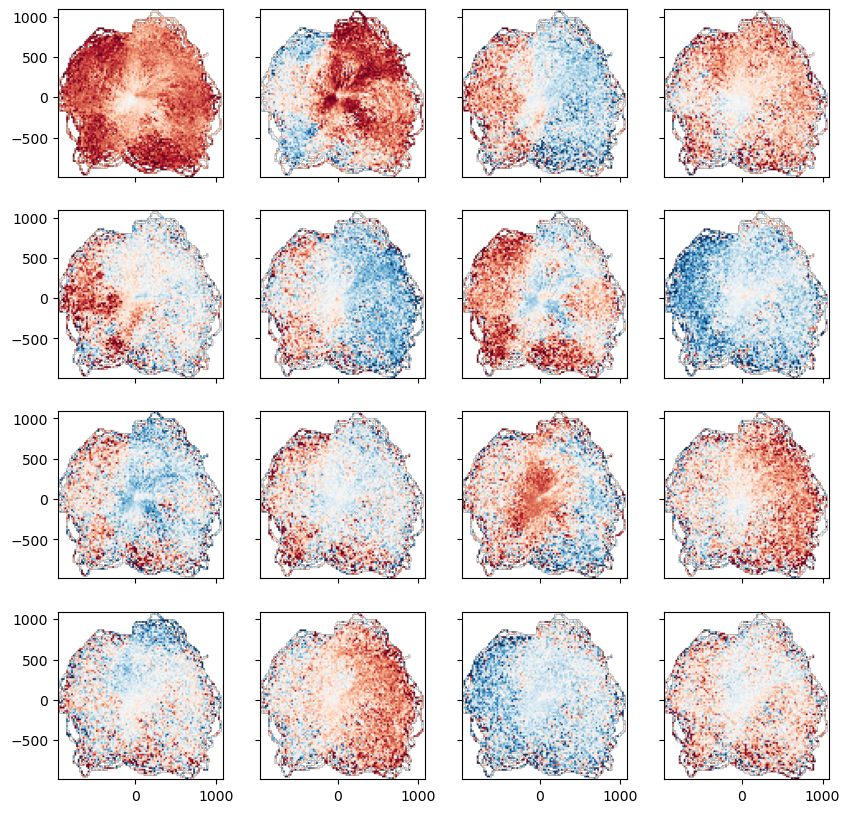

In [ ]:
# val = val - np.nanmean(val)
n_r = int(np.sqrt(context_dim))
n_c = int(np.ceil(context_dim / n_r))
fig, ax = plt.subplots(nrows=n_r, ncols=n_c, figsize=(10, 10), sharex=True, sharey=True)
ax = np.ravel(ax)
for i, a in enumerate(ax):
    val = c_mid[:, :, i].T
    val = val / np.nanpercentile(np.abs(val), 97)

    a.imshow(
        val,
        cmap="RdBu",
        clim=(-1, 1),
        extent=(b1[0], b1[-1], b2[0], b2[-1]),
        origin="lower",
    )
    # plt.colorbar()

In [ ]:
len(trials_df)

500

In [ ]:
analyzed_interval = (-0, 2)
feature_times = []
feature = []
valid_intervals = []

for i, trial in tqdm(trials_df.iterrows()):

    target = trial.target_pos[-1]

    st = trial.move_onset_time + analyzed_interval[0]
    en = min(trial.move_onset_time + analyzed_interval[1], trial.stop_time)

    ind_t = np.logical_and(
        behavior_df.index.values >= st,
        behavior_df.index.values <= en,
    )

    feature_times.append(behavior_df.index.values[ind_t])

    pos = behavior_df[["hand_pos_x", "hand_pos_y"]].values[ind_t]
    dist_to_target = np.linalg.norm(pos - target, axis=1)
    feature.append(dist_to_target)

    valid_intervals.append(
        np.array(
            [
                trial.move_onset_time + analyzed_interval[0],
                trial.move_onset_time + analyzed_interval[1],
            ]
        )
    )
    # if len(feature) > 50:
    #     break


# j = 23
# plt.plot(feature_times[j] - trial.move_onset_time, feature[j])

feature = np.concatenate(feature)
feature_times = np.concatenate(feature_times)
# feature = np.log10(feature + 1e-3)

feature_name = "distance_to_target"
bins = 50

500it [00:04, 107.02it/s]


In [ ]:
# feature_times = behavior_df.index.values
# feature_name = "log 10 hand speed (cm/s)"
# feature = (behavior_df["hand_vel_x"].values**2 + behavior_df["hand_vel_y"].values**2)**0.5
# feature = np.log10(feature + 1e-4)
# bins = np.linspace(-1,3,100)
# valid_intervals = reach_intervals

c_binned, bins = analysis.bin_context_by_feature(
    feature=feature,
    feature_times=feature_times,
    pca=True,
    valid_intervals=valid_intervals,
    bins=bins,
)

c_mid = np.array(
    [
        np.nanmedian(b, axis=0) if len(b) else np.nan * np.zeros(context_dim)
        for b in c_binned
    ]
)
c_lo = np.array(
    [
        np.nanpercentile(b, 25, axis=0) if len(b) else np.nan * np.zeros(context_dim)
        for b in c_binned
    ]
)
c_hi = np.array(
    [
        np.nanpercentile(b, 75, axis=0) if len(b) else np.nan * np.zeros(context_dim)
        for b in c_binned
    ]
)

Text(0.5, 1.0, 'Context vs distance_to_target')

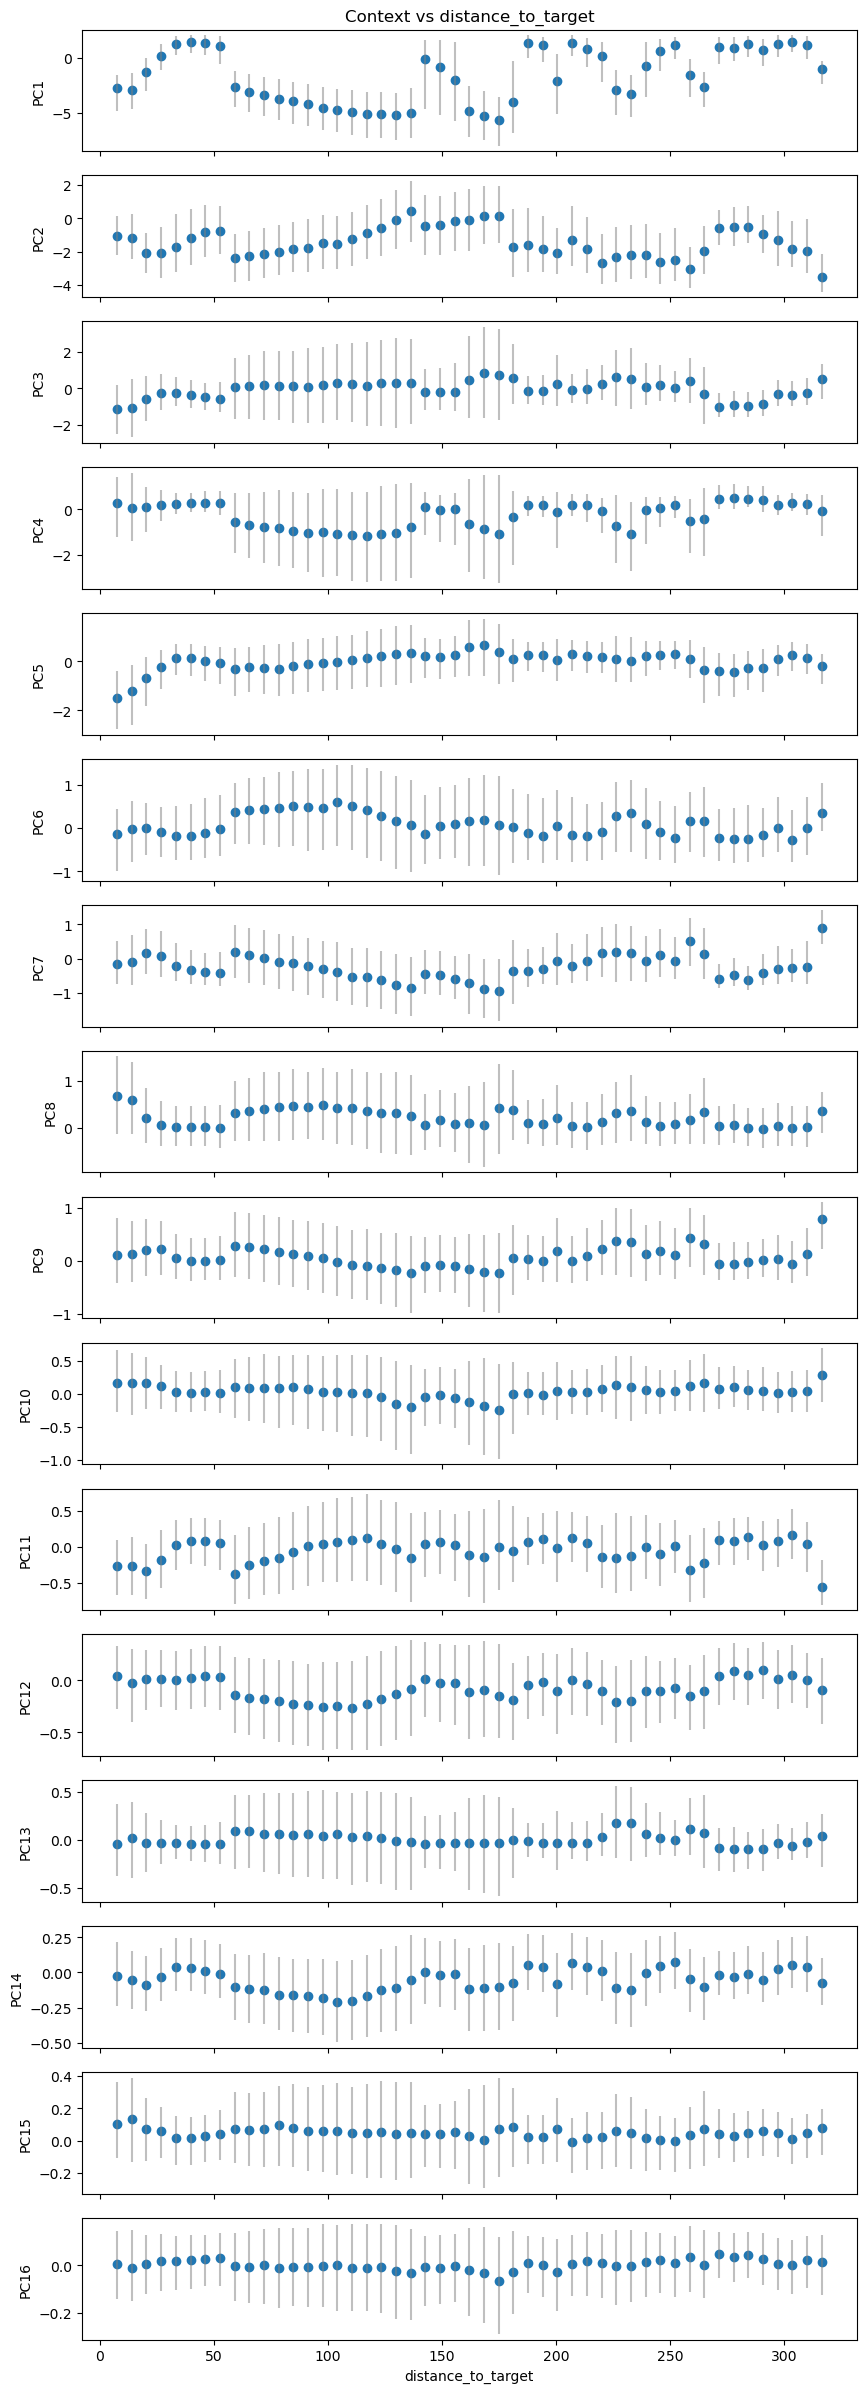

In [ ]:
fig, ax = plt.subplots(nrows=context_dim, figsize=(10, 30), sharex=True)
for i, a in enumerate(ax):
    a.scatter(
        bins[1:],
        c_mid[:, i],
        # s=1,
        # alpha=0.5,
    )
    a.vlines(bins[1:], c_lo[:, i], c_hi[:, i], color="gray", alpha=0.5)
    a.set_ylabel(f"PC{i+1}")

plt.xlabel(feature_name)
ax[0].set_title(f"Context vs {feature_name}")

# shared space neuron tuning analysis

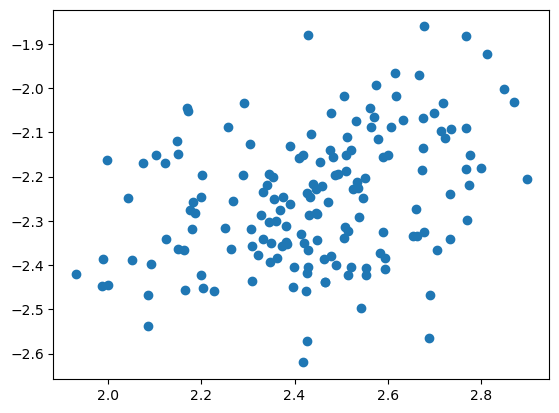

In [ ]:
W = analysis.params["params"]["embedding"]["encoder"]["encoder_matrix"]

P = analysis.pca.components_.T

W.shape, P.shape

# W = W @P
W = analysis.pca.transform(W)


i, j = 0, 1
plt.scatter(W[:, i], W[:, j])

In [ ]:
W = analysis.params["params"]["embedding"]["encoder"]["encoder_matrix"]

# projections of preparatory and movement spaces
[Paper](https://www.nature.com/articles/ncomms13239) Figures 5 + 6

In [ ]:
analysis_prep = analysis.copy()
analysis_prep.fit_context_pca(
    fit_intervals=preparatory_intervals,
)  # interpolated=True)
analysis_prep.embed_context_pca()

analysis_active = analysis.copy()
analysis_active.fit_context_pca(
    fit_intervals=active_reach_intervals,
)  # interpolated=True)
analysis_active.embed_context_pca()

/tmp/ipykernel_2417405/1421814163.py:75: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  a.scatter(


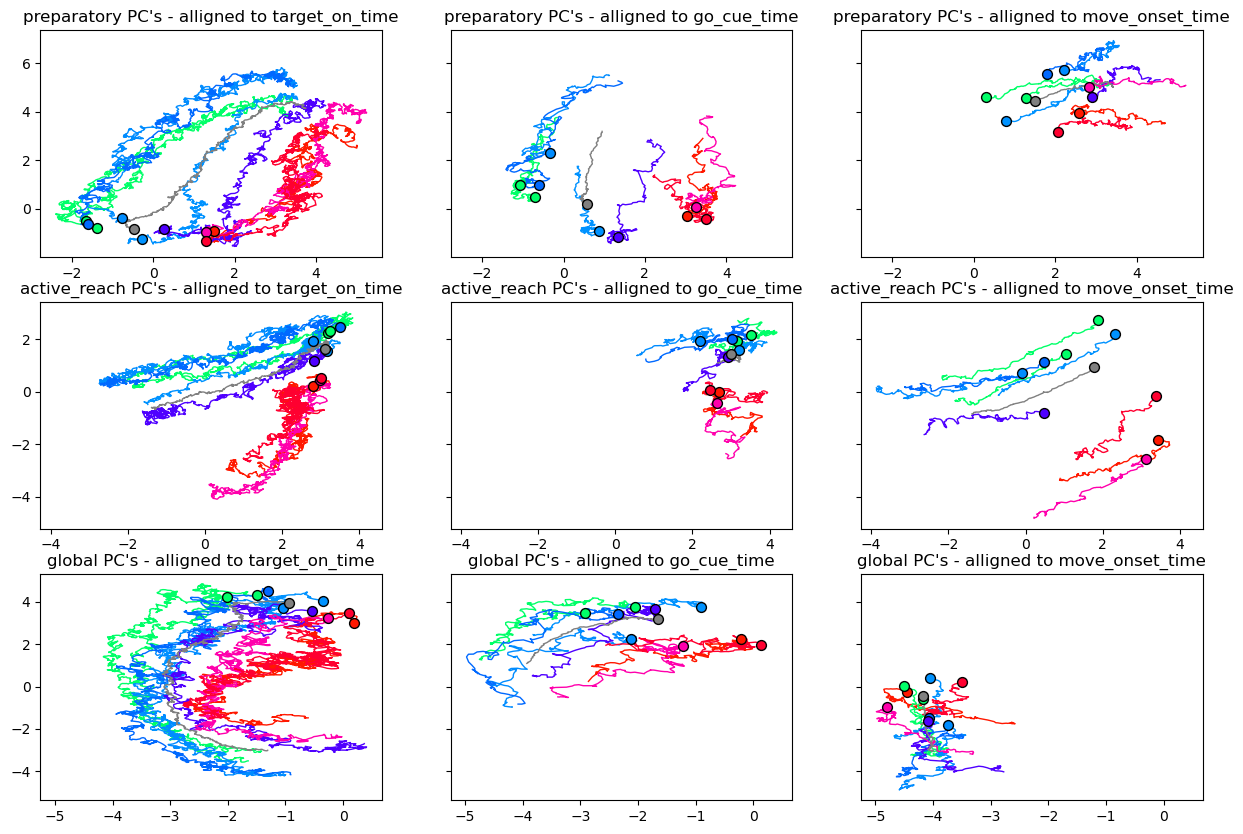

: 

In [ ]:
# start_times = trials_df.move_onset_time.values
# alignment = "move_onset_time"

# start_times = trials_df.go_cue_time.values

plot_dims = [0, 1]
interval_info = []
interval_info.append(
    dict(
        start_times=trials_df.target_on_time.values,
        alignment="target_on_time",
        t_rng=(0.15, 1.45),
    )
)
interval_info.append(
    dict(
        start_times=trials_df.go_cue_time.values,
        alignment="go_cue_time",
        t_rng=(-0, 0.25),
    )
)
interval_info.append(
    dict(
        start_times=trials_df.move_onset_time.values,
        alignment="move_onset_time",
        t_rng=(0.0, 0.2),
    )
)

analysis_dict = {
    "preparatory": analysis_prep,
    "active_reach": analysis_active,
    "global": analysis,
}

fig, ax = plt.subplots(
    nrows=len(analysis_dict),
    ncols=len(interval_info),
    sharex="row",
    sharey="row",
    figsize=(15, 10),
)
reach_angle_groups = list(np.sort(trials_df.reach_angle.unique())) + [None]

from scipy.ndimage import gaussian_filter1d

for i_analysis, (analysis_name, analysis_) in enumerate(analysis_dict.items()):
    for i_info, info in enumerate(interval_info):
        start_times = info["start_times"]
        alignment = info["alignment"]
        t_rng = info["t_rng"]

        for i_reach, reach_angle in enumerate(reach_angle_groups):
            if reach_angle is None:
                color = "gray"
                ind_reach = np.ones(len(trials_df), dtype=bool)
            else:
                ind_reach = trials_df.reach_angle == reach_angle
                color = plt.cm.hsv((reach_angle + np.pi) / (2 * np.pi))

            response = analysis_.alligned_response(
                start_times[ind_reach], t_rng, pca=True
            )
            response = np.nanmean(response, axis=0)

            # response = np.array(
            #     [
            #         gaussian_filter1d(response[:, i], sigma=3)
            #         for i in range(response.shape[1])
            #     ]
            # ).T

            t = np.linspace(t_rng[0], t_rng[1], response.shape[0])

            a = ax[i_analysis, i_info]
            a.plot(
                response[:, plot_dims[0]],
                response[:, plot_dims[1]],
                label=f"Angle {reach_angle:.2f} rad" if reach_angle else "all trials",
                color=color,
                lw=1,
                zorder=-1,
            )
            a.scatter(
                response[0, plot_dims[0]],
                response[0, plot_dims[1]],
                s=50,
                alpha=1,
                c=color,
                edgecolor="k",
                label=(
                    f"{alignment} + {t_rng[0]}s"
                    if i_reach == len(trials_df.reach_angle.unique()) - 1
                    else None
                ),
            )
            a.set_title(f"{analysis_name} PC's - alligned to {alignment}")
            # for i, a in enumerate(ax):
            #     a.plot(
            #         t, response[:, i], label=f"Angle {reach_angle:.2f} rad", color=color, lw=1
            #     )
            #     a.fill_between(
            #         t,
            #         response[:, i] - np.std(response[:, i]),
            #         response[:, i] + np.std(response[:, i]),
            #         alpha=0.1,
            #         facecolor=color,
            #     )
            #     a.set_ylabel(f"PC{i+1}")

            #     a.axvline(0, color="k", lw=0.5, ls="--")

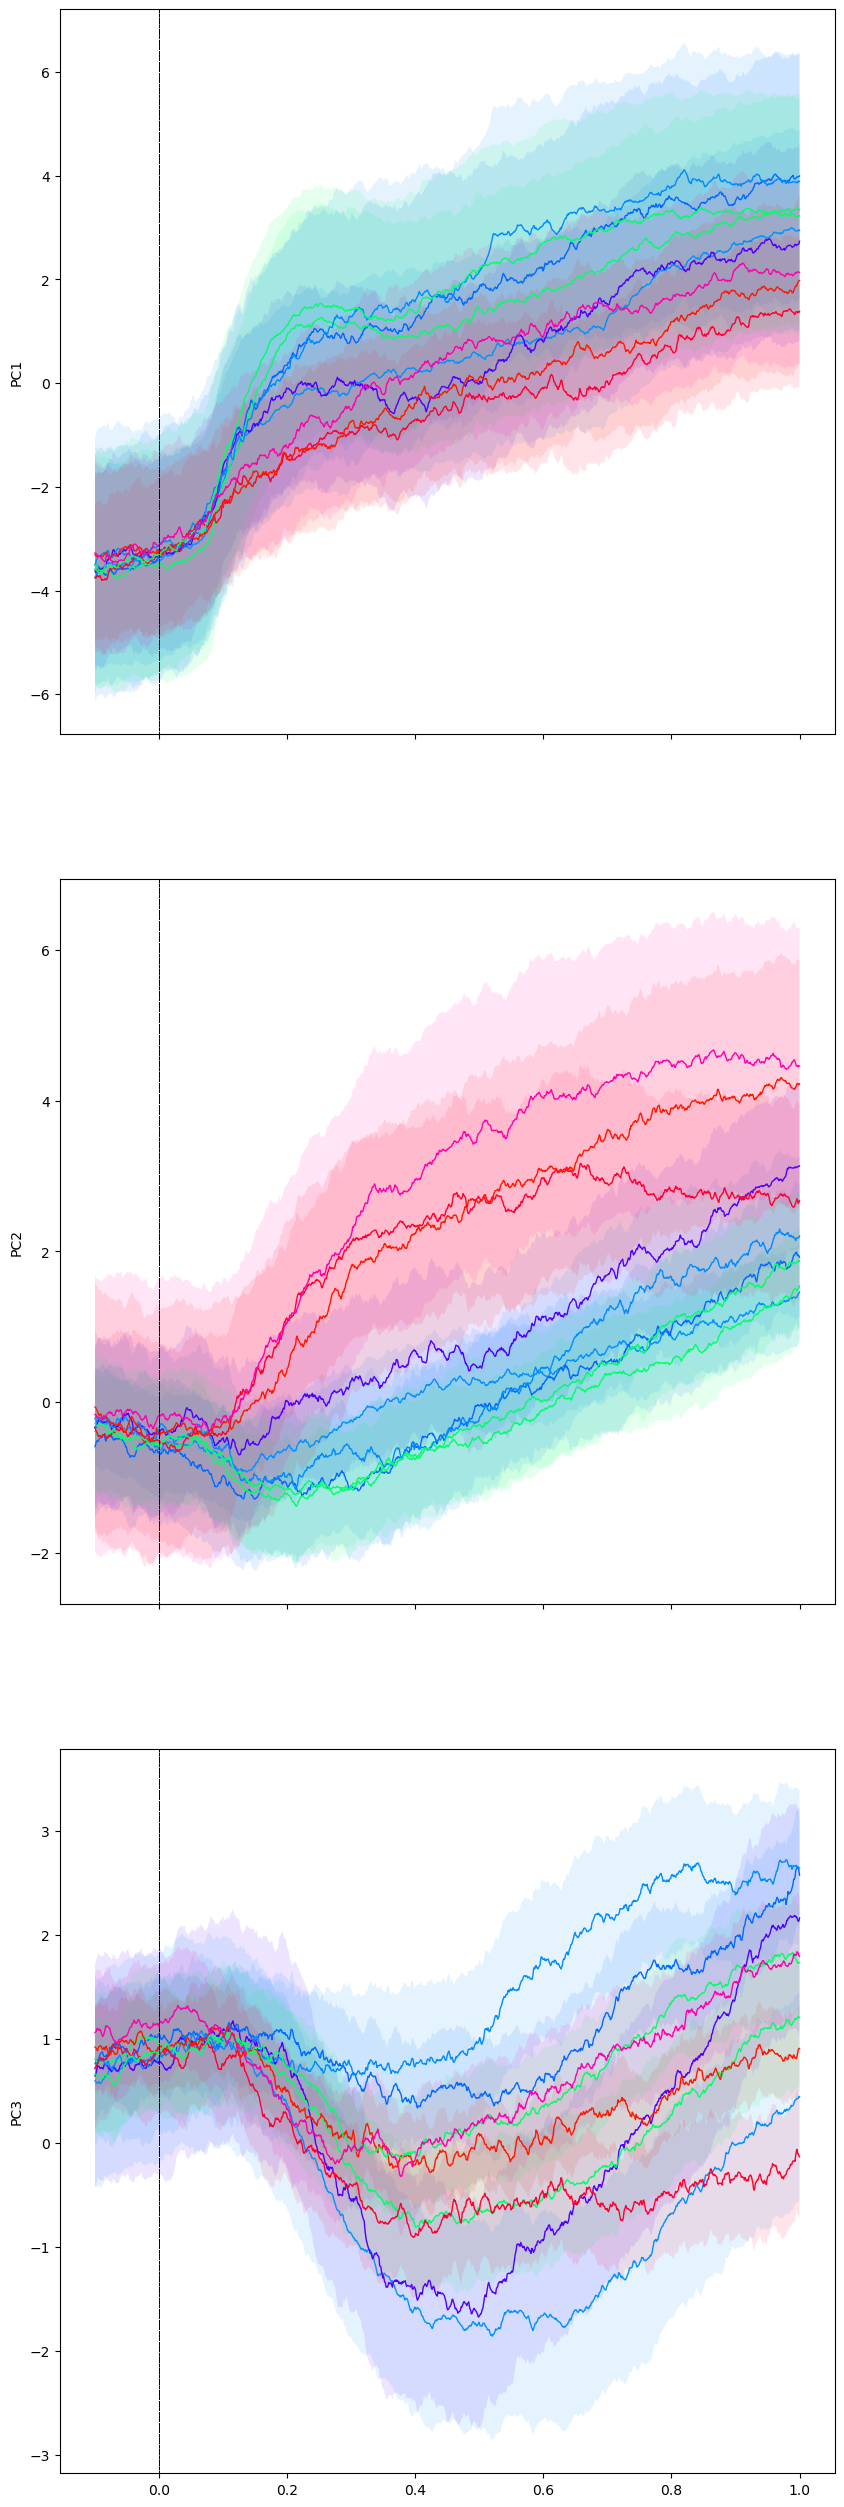

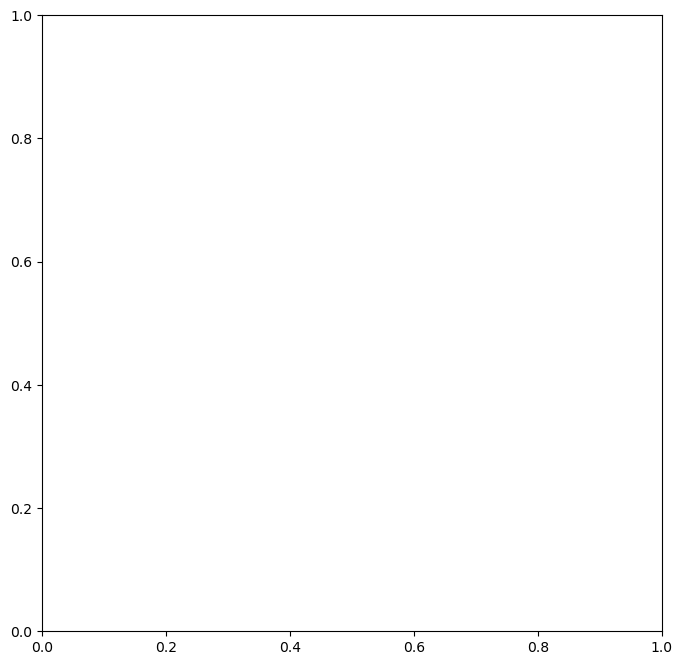

In [ ]:
# start_times = trials_df.move_onset_time.values
# alignment = "move_onset_time"

# start_times = trials_df.go_cue_time.values


start_times = trials_df.target_on_time.values
alignment = "target_on_time"
t_rng = (-0.2, 0.5)


fig, ax = plt.subplots(nrows=3, sharex=True, figsize=(10, 2 * context_dim))

two_d_fig = plt.figure(figsize=(8, 8))
two_d_ax = two_d_fig.add_subplot(1, 1, 1)
# plot_dims = (2,5)
plot_dims = (6, 7)
plot_dims = (0, 1)
# plot_dims=(6,4)

for i_reach, reach_angle in enumerate(trials_df.reach_angle.unique()):
    ind_reach = trials_df.reach_angle == reach_angle
    response = analysis_prep.alligned_response(start_times[ind_reach], t_rng, pca=True)

    response = np.mean(response, axis=0)

    color = plt.cm.hsv((reach_angle + np.pi) / (2 * np.pi))
    t = np.linspace(t_rng[0], t_rng[1], response.shape[0])
    for i, a in enumerate(ax):
        a.plot(
            t, response[:, i], label=f"Angle {reach_angle:.2f} rad", color=color, lw=1
        )
        a.fill_between(
            t,
            response[:, i] - np.std(response[:, i]),
            response[:, i] + np.std(response[:, i]),
            alpha=0.1,
            facecolor=color,
        )
        a.set_ylabel(f"PC{i+1}")

        a.axvline(0, color="k", lw=0.5, ls="--")